Checking DNS pkt ratios in benign and malicious pcaps


## Importing Scapy 

In [0]:
!pip install scapy
from scapy.utils import RawPcapReader, rdpcap
from scapy.layers.l2 import Ether
from scapy.layers.dns import DNS, DNSQR
from scapy.layers.inet import IP, TCP, UDP

     |████████████████████████████████| 911kB 8.5MB/s 
  Created wheel for scapy: filename=scapy-2.4.3-py2.py3-none-any.whl size=1043873 sha256=30f75d6e8b88a71aa7a03932c1037f5b85f961b85e42a081d0a17223629f1142
  Stored in directory: /root/.cache/pip/wheels/95/bf/51/905b3e84ec4ca910ce4ae92173c7334623105a265bdd1d9438
Successfully built scapy


Mount G Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


File list for parsing

In [0]:
pcap_name_list = '/content/drive/My Drive/Botnet Dataset/shreyyash/pcap_test_list.txt'

with open(pcap_name_list, 'r') as pcap_list:
    data = pcap_list.read()
    print (f'Following files will be parsed\n{data}')

Following files will be parsed
/content/drive/My Drive/Botnet Dataset/CTU DATASET/CTU-13-Dataset/6/botnet-capture-20110816-donbot.pcap


Add file to parse list

In [0]:
with open(pcap_name_list, 'a') as pcap_list:
    new_path = '\n' + str(input('Enter path of file to add to list: ')) 
    pcap_list.write(new_path)

Enter path of file to add to list: /content/drive/My Drive/Botnet Dataset/CTU DATASET/CTU-13-Dataset/8/botnet-capture-20110816-qvod.pcap


Fn to open txt file and pass pcap file names

In [0]:
def pcap_name_read():
    with open(pcap_name_list, 'r') as pcap_list:
        names = pcap_list.read()
        pcap_names = names.split('\n')

    #plot_data = []    
    for file_name in pcap_names:
        pcap_streams(file_name)
        pcap_flows_manual(file_name)
        plot_data = pcap_pkt_data(file_name)
        pcap_plot(plot_data)
        txt_Download(file_name,plot_data)
    print('EOP')

Fn to make uni directional flows, count DNS flows and show %s using rdpcap

In [0]:
def pcap_streams(file_name):
    pcap_data = rdpcap(file_name)
    print (f'{file_name} read')

    pcap_streams = pcap_data.sessions()    # extracting flows (Unidirectiuonal)

    #Counting DNS Flows from total flows
    dns_count = 0
    dnsPortNo_matchPattern = ':53 '
    for stream_name in pcap_streams.keys():
        if dnsPortNo_matchPattern in (stream_name + " "):
            dns_count += 1
 
    print (f'{dns_count} DNS Flows and {len (pcap_streams)} Total flows in PCAP file')
    print (f'Ratio of DNS flows to Total Flows is {(dns_count*100)/(len (pcap_streams))}%')

Manual flows( for cross checking)

In [0]:
def pcap_flows_manual(file_name):
    '''presently checked under fn pcap_pkt_data and not here.
    aim is to read file once and extract all reqd data instead of parsing in two 
    diff fns.'''
    pass

Fn to count DNS pkts and show %s using RawPcapReader

In [82]:
%%time
def pcap_pkt_data(file_name):
    #DNS pkt count in total pkts
    i = 0   #pkt count
    dns_pkt_count = 0
    dns_flows_dict = {}      
    dns_plot = []            
    for (pkt_data, pkt_metadata) in RawPcapReader(file_name):
        frm = Ether(pkt_data)
        i += 1

        try:
            if DNS in frm and frm[IP].proto == 17:         
                if (frm[UDP].sport == 53) or (frm[UDP].dport == 53):
                    dns_pkt_count += 1

                    #For flows as per format of STF
                    '''
                    time = (str(pkt_metadata.sec) +'.' + str(pkt_metadata.usec))
                    dns_flows_data = str('UDP ' + str(frm[IP].src)+ ':' + str(frm[UDP].sport) + 
                                ' > ' + str(frm[IP].dst) + ':' +  str(frm[UDP].dport))
                    
                    if dns_plot_data in dns_plot_dict.keys():
                        dns_plot_dict[dns_plot_data] += ',1'
                    else:
                        dns_plot_dict[dns_plot_data] = str(time)
                    '''
                    
                    #Data extraction for plotting
                    time = (str(pkt_metadata.sec) +'.' + str(pkt_metadata.usec))
                    dns_plot.append(([i, float(time), (frm[IP].src), frm[UDP].sport, 
                                         frm[IP].dst, frm[UDP].dport, frm[DNS].qr, 
                                         frm[DNS].id, frm[DNSQR].qname]))
                    
        except:
            print (f'check pkt no {i}')

    print(f'{dns_pkt_count}  DNS pkts from total {i} pkts, ratio is {(dns_pkt_count*100)/(i)}%\n')
    #print (dns_plot)
    return dns_plot

CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 10.5 µs


In [0]:
def txt_Download(file_name, plot_data):
    '''Download data extracted from previous fn as csvs in txt file'''
    from google.colab import files

    #print('in txt_downlaod')
    name = file_name.split('/')
    file_name = name[(len(name)) -1]
    file_name += '.txt'

    my_file = open(file_name,'w')

    file_dnld = 'Pkt number, Time Stamp, Source IP, Source Port, Dest IP, Dest Port, DNS query/reply, Txn id, Query Name\n'
                
    for i in range(len(plot_data)):
        for j in range(9):
            file_dnld += str(plot_data[i][j])
            file_dnld += ','
        file_dnld += '\n'   
    my_file.write(file_dnld)
    my_file.close()

    files.download(file_name)
    print('Write Complete') 


In [0]:
#def pcap_plot(plot_data):
    '''for printing a plot between two specific vars'''
    
    data = plot_data
    #num,time,s.ip,s.port,d.ip,d.port,q/r,dnsID,query = zip (*data)
    num,time,sIP,sPORT,dIP, dPORT,qORr,dnsID,query = zip(*data)
    new_time = list(map(lambda x: x - time[0], time))

    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.rc('figure', figsize=(24,8))

    plt.scatter(new_time, sIP)
    plt.xlabel('Pkt number(Only DNS pkt times shown)')
    plt.ylabel('Time of query')
    plt.title('DNS query vs Time')
    #plt.yscale('log')
    plt.show()

    plt.scatter(num, new_time)
    plt.xlabel('Pkt number(Only DNS pkt times shown)')
    plt.ylabel('Time of query')
    plt.title('DNS query vs Time')
    #plt.yscale('log')
    plt.show()


In [0]:
def pcap_plot(plot_data):
    '''printing all vars against every other var'''

    import pandas as pd
    import seaborn as sb
    import matplotlib.pyplot as plt
   
    print('Pair wise plotting')
    num,time,sIP,sPORT,dIP, dPORT,qORr,dnsID,query = zip(*plot_data)
    plot = pd.DataFrame ({'num':num, 'time': time, 'sIP': sIP, 'sPort': sPORT,
                          'dIP': dIP, 'dPort': dPORT, 'q/r': qORr, 
                          'dnsID': dnsID, 'query': query})
    
    sb.pairplot(plot)
    plt.show()
    

Main Fn of file

/content/drive/My Drive/Botnet Dataset/CTU DATASET/CTU-13-Dataset/6/botnet-capture-20110816-donbot.pcap read
48 DNS Flows and 4840 Total flows in PCAP file
Ratio of DNS flows to Total Flows is 0.9917355371900827%
81  DNS pkts from total 24764 pkts, ratio is 0.3270877079631723%

Pair wise plotting


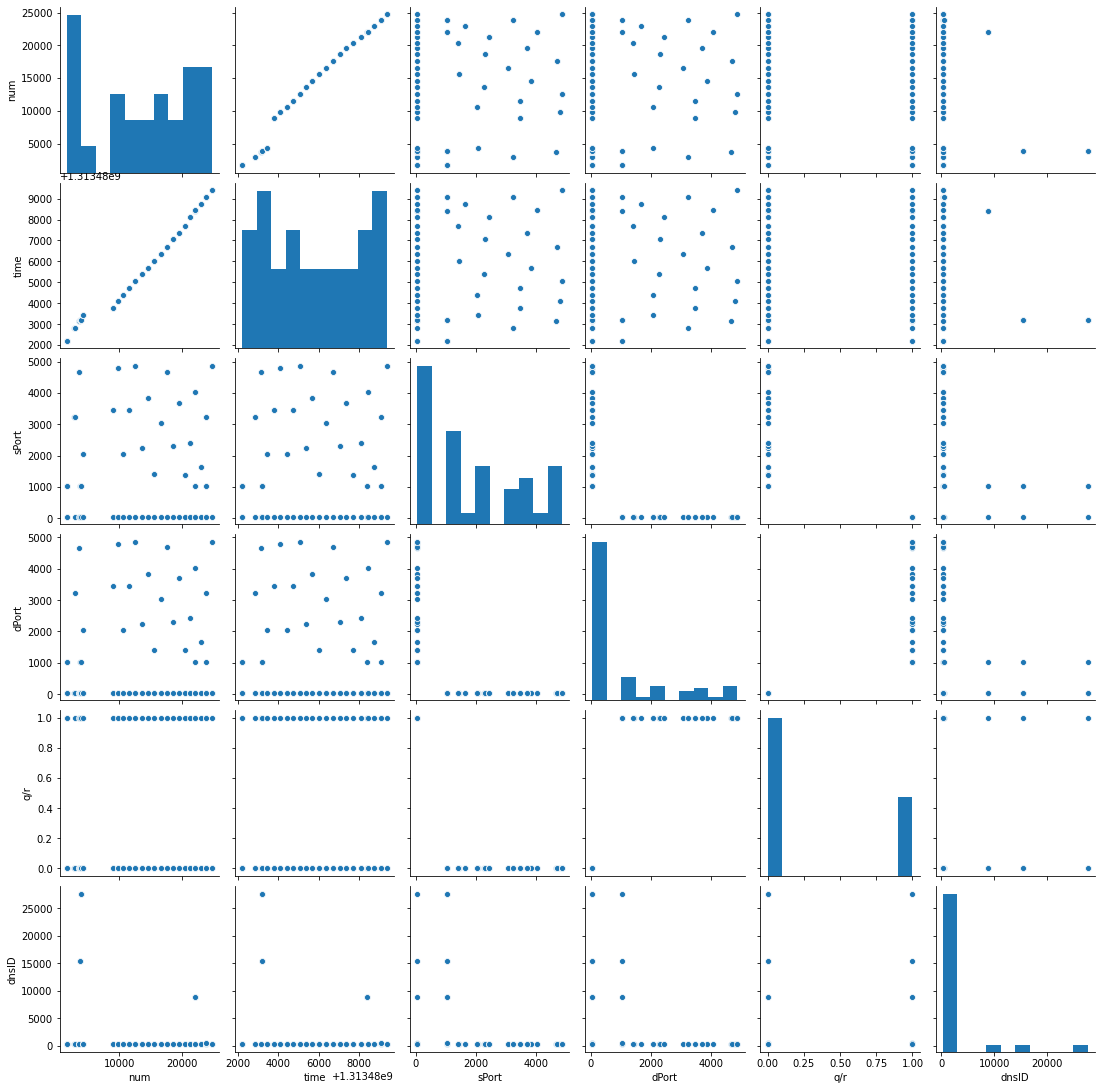

Write Complete
EOP
CPU times: user 22.9 s, sys: 2.06 s, total: 25 s
Wall time: 25.2 s


In [83]:
%%time
pcap_name_read()